In [1]:
import re
import numpy as np
import pandas as pd
import operator
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
# Import Dataset
df = pd.read_csv('data/cisco/cisco_cleaned.csv', header=None)
# print(df.target_names.unique())
df.head()

,0,1
0,0,Introduction to Clientless SSL VPN Clientless ...
1,2,Feature History for AnyConnect Connections The...
2,3,Configuring Smart Tunnel Access The following ...
3,4,Dynamic PAT Disadvantages and Advantages Dynam...
4,5,In order to create a group policy and link it ...


In [7]:
# Convert to list
data = df[1].values.tolist()
pprint(data[:1])

['Introduction to Clientless SSL VPN Clientless SSL VPN enables end users to '
 'securely access resources on the corporate network from anywhere using an '
 'SSL-enabled Web browser. The user first authenticates with a Clientless SSL '
 'VPN gateway, which then allows the user to access pre-configured network '
 'resources. Note Security contexts (also called firewall multimode) and '
 'Active/Active stateful failover are not supported when Clientless SSL VPN is '
 'enabled. Clientless SSL VPN creates a secure, remote-access VPN tunnel to an '
 'ASA using a web browser without requiring a software or hardware client. It '
 'provides secure and easy access to a broad range of web resources and both '
 'web-enabled and legacy applications from almost any device that can connect '
 'to the Internet via HTTP. They include: Internal websites. Web-enabled '
 'applications. NT/Active Directory file shares. Microsoft Outlook Web Access '
 'Exchange Server 2000, 2003, 2007, and 2013. Microsoft

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['introduction', 'to', 'clientless', 'ssl', 'vpn', 'clientless', 'ssl', 'vpn', 'enables', 'end', 'users', 'to', 'securely', 'access', 'resources', 'on', 'the', 'corporate', 'network', 'from', 'anywhere', 'using', 'an', 'ssl', 'enabled', 'web', 'browser', 'the', 'user', 'first', 'authenticates', 'with', 'clientless', 'ssl', 'vpn', 'gateway', 'which', 'then', 'allows', 'the', 'user', 'to', 'access', 'pre', 'configured', 'network', 'resources', 'note', 'security', 'contexts', 'also', 'called', 'firewall', 'multimode', 'and', 'active', 'active', 'stateful', 'failover', 'are', 'not', 'supported', 'when', 'clientless', 'ssl', 'vpn', 'is', 'enabled', 'clientless', 'ssl', 'vpn', 'creates', 'secure', 'remote', 'access', 'vpn', 'tunnel', 'to', 'an', 'asa', 'using', 'web', 'browser', 'without', 'requiring', 'software', 'or', 'hardware', 'client', 'it', 'provides', 'secure', 'and', 'easy', 'access', 'to', 'broad', 'range', 'of', 'web', 'resources', 'and', 'both', 'web', 'enabled', 'and', 'legacy'

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['introduction', 'to', 'clientless', 'ssl', 'vpn', 'clientless', 'ssl', 'vpn', 'enables', 'end', 'users', 'to', 'securely', 'access', 'resources', 'on', 'the', 'corporate', 'network', 'from', 'anywhere', 'using', 'an', 'ssl', 'enabled', 'web', 'browser', 'the', 'user', 'first', 'authenticates', 'with', 'clientless', 'ssl', 'vpn', 'gateway', 'which', 'then', 'allows', 'the', 'user', 'to', 'access', 'pre', 'configured', 'network', 'resources', 'note', 'security', 'contexts', 'also', 'called', 'firewall', 'multimode', 'and', 'active', 'active', 'stateful', 'failover', 'are', 'not', 'supported', 'when', 'clientless', 'ssl', 'vpn', 'is', 'enabled', 'clientless', 'ssl', 'vpn', 'creates', 'secure', 'remote', 'access', 'vpn', 'tunnel', 'to', 'an', 'asa', 'using', 'web', 'browser', 'without', 'requiring', 'software', 'or', 'hardware', 'client', 'it', 'provides', 'secure', 'and', 'easy', 'access', 'to', 'broad', 'range', 'of', 'web', 'resources', 'and', 'both', 'web', 'enabled', 'and', 'legacy',

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['introduction', 'clientless', 'ssl', 'vpn', 'clientless', 'ssl', 'vpn', 'enable', 'end', 'user', 'securely', 'access', 'resource', 'corporate', 'network', 'anywhere', 'use', 'ssl', 'enable', 'web', 'browser', 'user', 'first', 'authenticate', 'clientless', 'ssl', 'vpn', 'gateway', 'allow', 'user', 'access', 'pre', 'configured', 'network', 'resource', 'note', 'security', 'context', 'also', 'call', 'firewall', 'multimode', 'active', 'active', 'stateful', 'failover', 'support', 'clientless', 'ssl', 'vpn', 'enable', 'clientless', 'ssl', 'vpn', 'create', 'secure', 'remote', 'access', 'vpn', 'tunnel', 'asa', 'use', 'web', 'browser', 'require', 'software', 'hardware', 'client', 'provide', 'secure', 'easy', 'access', 'broad', 'range', 'web', 'resource', 'web', 'enable', 'legacy', 'application', 'almost', 'device', 'connect', 'internet', 'http', 'include', 'internal', 'website', 'web', 'enable', 'application', 'nt', 'active', 'directory', 'file', 'share', 'microsoft', 'outlook', 'web', 'access

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 9), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 4), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 7), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 5), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 4), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 2), (51, 1), (52, 1), (53, 4), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 3), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 6), (67, 4), (68, 1), (69, 2), (70, 4), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 9), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 2), (86, 3), (87, 7), (88, 8), (89, 7), (90, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('access', 9),
  ('active', 3),
  ('administrator', 1),
  ('allow', 1),
  ('almost', 1),
  ('also', 1),
  ('anywhere', 1),
  ('app', 1),
  ('application', 4),
  ('asa', 2),
  ('authenticate', 2),
  ('authentication', 1),
  ('base', 1),
  ('basis', 1),
  ('broad', 1),
  ('browser', 2),
  ('call', 1),
  ('client', 1),
  ('clientless', 7),
  ('configure', 1),
  ('configured', 1),
  ('connect', 1),
  ('connection', 2),
  ('context', 1),
  ('corporate', 1),
  ('create', 1),
  ('device', 1),
  ('direct', 1),
  ('directory', 1),
  ('easy', 1),
  ('enable', 5),
  ('end', 1),
  ('exchange', 2),
  ('failover', 1),
  ('file', 1),
  ('firewall', 1),
  ('first', 1),
  ('forwarding', 1),
  ('gateway', 1),
  ('group', 1),
  ('hardware', 1),
  ('http', 2),
  ('include', 1),
  ('interact', 1),
  ('internal', 4),
  ('internet', 1),
  ('introduction', 1),
  ('later', 1),
  ('layer', 2),
  ('legacy', 1),
  ('microsoft', 2),
  ('multimode', 1),
  ('must', 1),
  ('network', 4),
  ('note', 1),
  ('nt', 1),

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.117*"group" + 0.041*"policy" + 0.033*"connection" + 0.030*"attribute" + '
  '0.029*"name" + 0.028*"tunnel" + 0.028*"pool" + 0.022*"server" + 0.020*"use" '
  '+ 0.019*"default"'),
 (1,
  '0.072*"scan" + 0.064*"host" + 0.028*"file" + 0.028*"csc" + 0.028*"step" + '
  '0.024*"asa" + 0.023*"configuration" + 0.021*"ssm" + 0.020*"module" + '
  '0.019*"asdm"'),
 (2,
  '0.102*"address" + 0.052*"nat" + 0.050*"network" + 0.036*"rule" + '
  '0.034*"interface" + 0.032*"object" + 0.028*"port" + 0.026*"use" + '
  '0.024*"destination" + 0.024*"source"'),
 (3,
  '0.067*"box" + 0.053*"add" + 0.052*"dialog" + 0.041*"field" + 0.038*"select" '
  '+ 0.037*"edit" + 0.033*"click" + 0.027*"step" + 0.024*"check" + '
  '0.020*"list"'),
 (4,
  '0.106*"client" + 0.071*"vpn" + 0.032*"anyconnect" + 0.023*"enable" + '
  '0.020*"asa" + 0.020*"ipsec" + 0.018*"remote" + 0.018*"network" + '
  '0.018*"tunnel" + 0.018*"easy"'),
 (5,
  '0.068*"snmp" + 0.029*"queue" + 0.029*"limit" + 0.022*"show" + 0.017*"trap" '
 

In [16]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -6.1135885852796354
Coherence Score:  0.48463966034295025


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [27]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [28]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('license', 0.09336007437467068),
   ('session', 0.06215361017851576),
   ('asa', 0.031694754875320356),
   ('vpn', 0.030792658535845226),
   ('base', 0.030726449630195676),
   ('feature', 0.025948373605819763),
   ('support', 0.023140012524517986),
   ('anyconnect', 0.022828278927084684),
   ('optional', 0.018960575355390096),
   ('time', 0.018121929217162453)]),
 (15,
  [('failover', 0.08904303333575314),
   ('interface', 0.07449916266355597),
   ('unit', 0.066291012588834),
   ('active', 0.05454326989268576),
   ('address', 0.044129758361474015),
   ('mac', 0.04025973700876888),
   ('standby', 0.025886087198139587),
   ('configuration', 0.021405273342161454),
   ('group', 0.02075442887146072),
   ('link', 0.019517824377129324)]),
 (2,
  [('ipsec', 0.04809289040285737),
   ('policy', 0.030474498268377025),
   ('crypto', 0.028227649667233973),
   ('peer', 0.02626230278738356),
   ('set', 0.02266476244095566),
   ('ikev', 0.021608485339958523),
   ('tunnel', 0.0191498648016962

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [44]:
# Can take a long time to run.
limit=40; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 4-topic model
Calculating 6-topic model
Calculating 8-topic model
Calculating 10-topic model
Calculating 12-topic model
Calculating 14-topic model
Calculating 16-topic model
Calculating 18-topic model
Calculating 20-topic model
Calculating 22-topic model
Calculating 24-topic model
Calculating 26-topic model
Calculating 28-topic model
Calculating 30-topic model
Calculating 32-topic model
Calculating 34-topic model
Calculating 36-topic model
Calculating 38-topic model


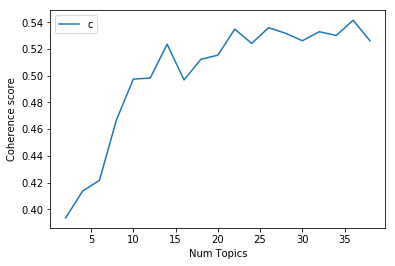

In [45]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [46]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.393614
Num Topics = 4  has Coherence Value of 0.41365
Num Topics = 6  has Coherence Value of 0.421755
Num Topics = 8  has Coherence Value of 0.466834
Num Topics = 10  has Coherence Value of 0.497416
Num Topics = 12  has Coherence Value of 0.498222
Num Topics = 14  has Coherence Value of 0.52351
Num Topics = 16  has Coherence Value of 0.496779
Num Topics = 18  has Coherence Value of 0.512293
Num Topics = 20  has Coherence Value of 0.515294
Num Topics = 22  has Coherence Value of 0.534799
Num Topics = 24  has Coherence Value of 0.524141
Num Topics = 26  has Coherence Value of 0.535875
Num Topics = 28  has Coherence Value of 0.531741
Num Topics = 30  has Coherence Value of 0.526126
Num Topics = 32  has Coherence Value of 0.532847
Num Topics = 34  has Coherence Value of 0.530053
Num Topics = 36  has Coherence Value of 0.541448
Num Topics = 38  has Coherence Value of 0.526064


In [47]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 6
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.064*"step" + 0.054*"click" + 0.038*"add" + 0.037*"box" + 0.029*"choose" + '
  '0.026*"field" + 0.024*"configuration" + 0.024*"check" + 0.023*"dialog" + '
  '0.022*"select"'),
 (1,
  '0.109*"server" + 0.066*"user" + 0.040*"authentication" + 0.028*"configure" '
  '+ 0.028*"attribute" + 0.028*"aaa" + 0.026*"password" + 0.022*"access" + '
  '0.020*"group" + 0.019*"username"'),
 (2,
  '0.043*"message" + 0.031*"log" + 0.026*"syslog" + 0.025*"show" + '
  '0.025*"context" + 0.015*"level" + 0.015*"snmp" + 0.014*"system" + '
  '0.014*"limit" + 0.013*"statistic"'),
 (3,
  '0.067*"license" + 0.061*"asa" + 0.040*"session" + 0.024*"support" + '
  '0.024*"base" + 0.023*"feature" + 0.021*"anyconnect" + 0.019*"module" + '
  '0.019*"vpn" + 0.016*"version"'),
 (4,
  '0.077*"interface" + 0.049*"failover" + 0.036*"unit" + 0.032*"address" + '
  '0.029*"active" + 0.025*"context" + 0.024*"cluster" + 0.021*"mac" + '
  '0.021*"configuration" + 0.021*"mode"'),
 (5,
  '0.043*"route" + 0.042*"interface" 

In [48]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.2810,"file, application, ssl, tunnel, vpn, clientles...",Introduction to Clientless SSL VPN Clientless ...
1,1,8.0,0.2367,"group, ipsec, connection, tunnel, address, mod...",Feature History for AnyConnect Connections The...
2,2,13.0,0.5369,"file, application, ssl, tunnel, vpn, clientles...",Configuring Smart Tunnel Access The following ...
3,3,6.0,0.3615,"address, nat, network, object, port, interface...",Dynamic PAT Disadvantages and Advantages Dynam...
4,4,0.0,0.3369,"step, click, add, box, choose, field, configur...",In order to create a group policy and link it ...
5,5,4.0,0.1145,"interface, failover, unit, address, active, co...",Reloading by Removing and Re-adding the Contex...
6,6,3.0,0.2137,"license, asa, session, support, base, feature,...",Licensing Requirements for Twice NAT Model Li...
7,7,9.0,0.4549,"certificate, cisco, proxy, ca, server, tls, ph...",The following table shows the licensing requir...
8,8,1.0,0.5422,"server, user, authentication, configure, attri...",Configuring Microsoft Active Directory Setting...
9,9,1.0,0.3898,"server, user, authentication, configure, attri...",Normal SDI Authentication Login A normal login...


In [49]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8744,"step, click, add, box, choose, field, configur...",Using the CSC SSM GUI This section describes h...
1,1.0,0.8527,"server, user, authentication, configure, attri...",Thia example shows the output of debug dap err...
2,2.0,0.8248,"message, log, syslog, show, context, level, sn...",event list: Message Class Severity Message ID....
3,3.0,0.8690,"license, asa, session, support, base, feature,...",This section describes the licenses available ...
4,4.0,0.8778,"interface, failover, unit, address, active, co...",Configuration Examples for ASA Clustering Samp...
5,5.0,0.8508,"route, interface, address, ipv, router, rout, ...",IPv6 is the next generation of the Internet Pr...
6,6.0,0.8761,"address, nat, network, object, port, interface...",NAT Basics The following topics explain some o...
7,7.0,0.7151,"client, vpn, policy, group, connection, tunnel...",Supported Cisco Attributes for LDAP Authorizat...
8,8.0,0.8607,"group, ipsec, connection, tunnel, address, mod...",debug crypto ipsec Displays the IPsec negotiat...
9,9.0,0.7997,"certificate, cisco, proxy, ca, server, tls, ph...",Media Engine Proxy for information. Step1 In t...


In [50]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: step, click, add, box, choose, field, configuration, check, dialog, select

Using the CSC SSM GUI This section describes how to configure features using the CSC SSM GUI, and includes the following topics: Web Mail SMTP Tab POP3 Tab File Transfer Updates Web Note To access the CSC SSM, you must reenter the CSC SSM password. Sessions in the CSC SSM browser time out after ten minutes of inactivity. If you close the CSC SSM browser and click another link in ASDM, you are not prompted for the CSC SSM password again, because one session is already open. To view whether or not web-related features are enabled and access the CSC SSM GUI for configuring these features, perform the following steps: Step 1 Choose Configuration > Trend Micro Content Security > Web . The URL Blocking and Filtering area is display-only and shows whether or not URL blocking is enabled on the CSC SSM. Step 2 Click Configure URL Blocking to open a screen for configuring URL blocking on the CSC 

In [51]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"step, click, add, box, choose, field, configur...",1177,0.0509
1,1.0,"server, user, authentication, configure, attri...",1749,0.0757
2,2.0,"message, log, syslog, show, context, level, sn...",1756,0.0760
3,3.0,"license, asa, session, support, base, feature,...",2350,0.1017
4,4.0,"interface, failover, unit, address, active, co...",2431,0.1052
5,5.0,"route, interface, address, ipv, router, rout, ...",1334,0.0577
6,6.0,"address, nat, network, object, port, interface...",1511,0.0654
7,7.0,"client, vpn, policy, group, connection, tunnel...",1785,0.0772
8,8.0,"group, ipsec, connection, tunnel, address, mod...",1518,0.0657
9,9.0,"certificate, cisco, proxy, ca, server, tls, ph...",1391,0.0602
